# Dependencias

In [51]:
import numpy as np 
import pandas as pd
import seaborn as sns
import neattext.functions as nfx
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Carga y análisis de los datos

In [16]:
df = pd.read_csv("./datasets/emotion_dataset_raw.csv")

In [17]:
df.head()

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


utilizamos la función "value_counts" para saber cuántas emociones están representadas en el dataset

In [18]:
df['Emotion'].value_counts()

Emotion
joy         11045
sadness      6722
fear         5410
anger        4297
surprise     4062
neutral      2254
disgust       856
shame         146
Name: count, dtype: int64

Mediante una gráfica de barras podemos ver la cantidad de ejemplos por emoción disponibles de manera más visual, esto nos permite hacer un análisis claro del desbalance en el dataset.

<Axes: xlabel='Emotion', ylabel='count'>

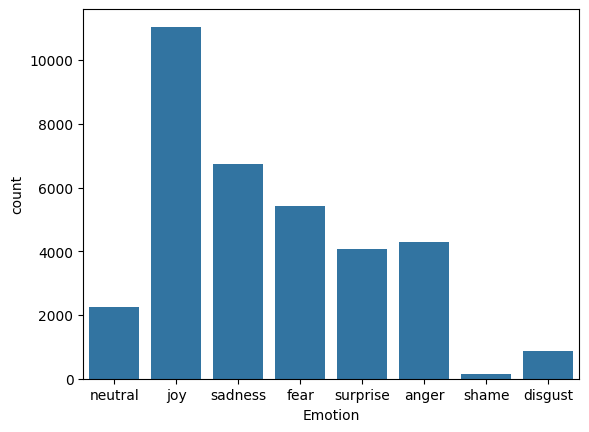

In [19]:
sns.countplot(x='Emotion',data=df)

Notemos que la emoción "shame" tiene muy pocos ejemplos (solamente 146), así mismo la emoción con más ejemplos es "joy", con la gráfica anterior podemos notar que nuestro dataset se encuentra desbalanceado.
Atenderemos a esta problemática mediante una técnica de data augmentation a través de chatGPT, con la que creamos artificialmente más observaciones con la emoción de "shame" a través de los siguientes prompts:
![image.png](imagenes/image.png)
\
Notemos que chatGPT sólo crea 50 ejemplos por prompt, por lo que seguimos haciendo más peticiones hasta llegar a un dataset de apoyo con 500 oraciones que representan a la clase "shame":
\
![image.png](imagenes/img2.png)
![image.png](imagenes/img3.png)
![image.png](imagenes/img4.png)


## Data Augmentation

Importamos el nuevo dataset creado y lo agregamos a nuestro dataset principal

In [25]:
augmented = pd.read_csv("./datasets/shame_dataset.csv")

In [26]:
augmented.head()

,Emotion,Text
0,shame,I shouldn’t have said that in the group chat.
1,shame,I feel so guilty for not standing up for you.
2,shame,I can't believe I forgot your birthday.
3,shame,That comment I made was out of line.
4,shame,I shouldn’t have spread that rumor.


In [27]:
augmented_df = pd.concat([df, augmented], ignore_index=True)

<Axes: xlabel='Emotion', ylabel='count'>

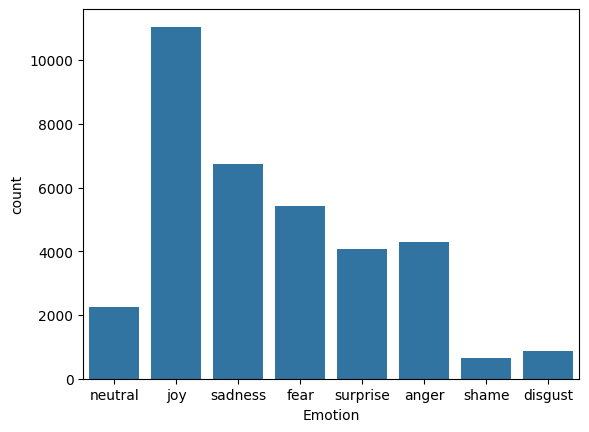

In [28]:
sns.countplot(x='Emotion',data=augmented_df)

## Limpieza de los datos

Para la limpieza de los datos utilizaremos la biblioteca de neattext, la cual permite hacer una limpieza rápida en texto, de emojis, caracteres especiales, mayusculas e incluso casos especiales como nombres de usuario detectados por el caracter "@".
Aquí podemos ver una lista con todas las funcionalidades de neattext:

In [29]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [30]:
augmented_df['Clean_Text'] = augmented_df['Text'].apply(nfx.remove_userhandles)
augmented_df['Clean_Text'] = augmented_df['Clean_Text'].apply(nfx.remove_emojis)
augmented_df['Clean_Text'] = augmented_df['Clean_Text'].apply(nfx.remove_stopwords)

In [31]:
augmented_df.head()

,Emotion,Text,Clean_Text
0,neutral,Why ?,?
1,joy,Sage Act upgrade on my to do list for tommorow.,Sage Act upgrade list tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,WAY HOMEGIRL BABY FUNERAL!!! MAN HATE FUNERALS...
3,joy,Such an eye ! The true hazel eye-and so brill...,eye ! true hazel eye-and brilliant ! Regular f...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,ugh babe.. hugggzzz u .! babe naamazed nga ako...


In [35]:
augmented_df.drop('Text', axis=1, inplace=True)

Como último paso de análisis checaremos las palabras más repetidas por cada sentimiento

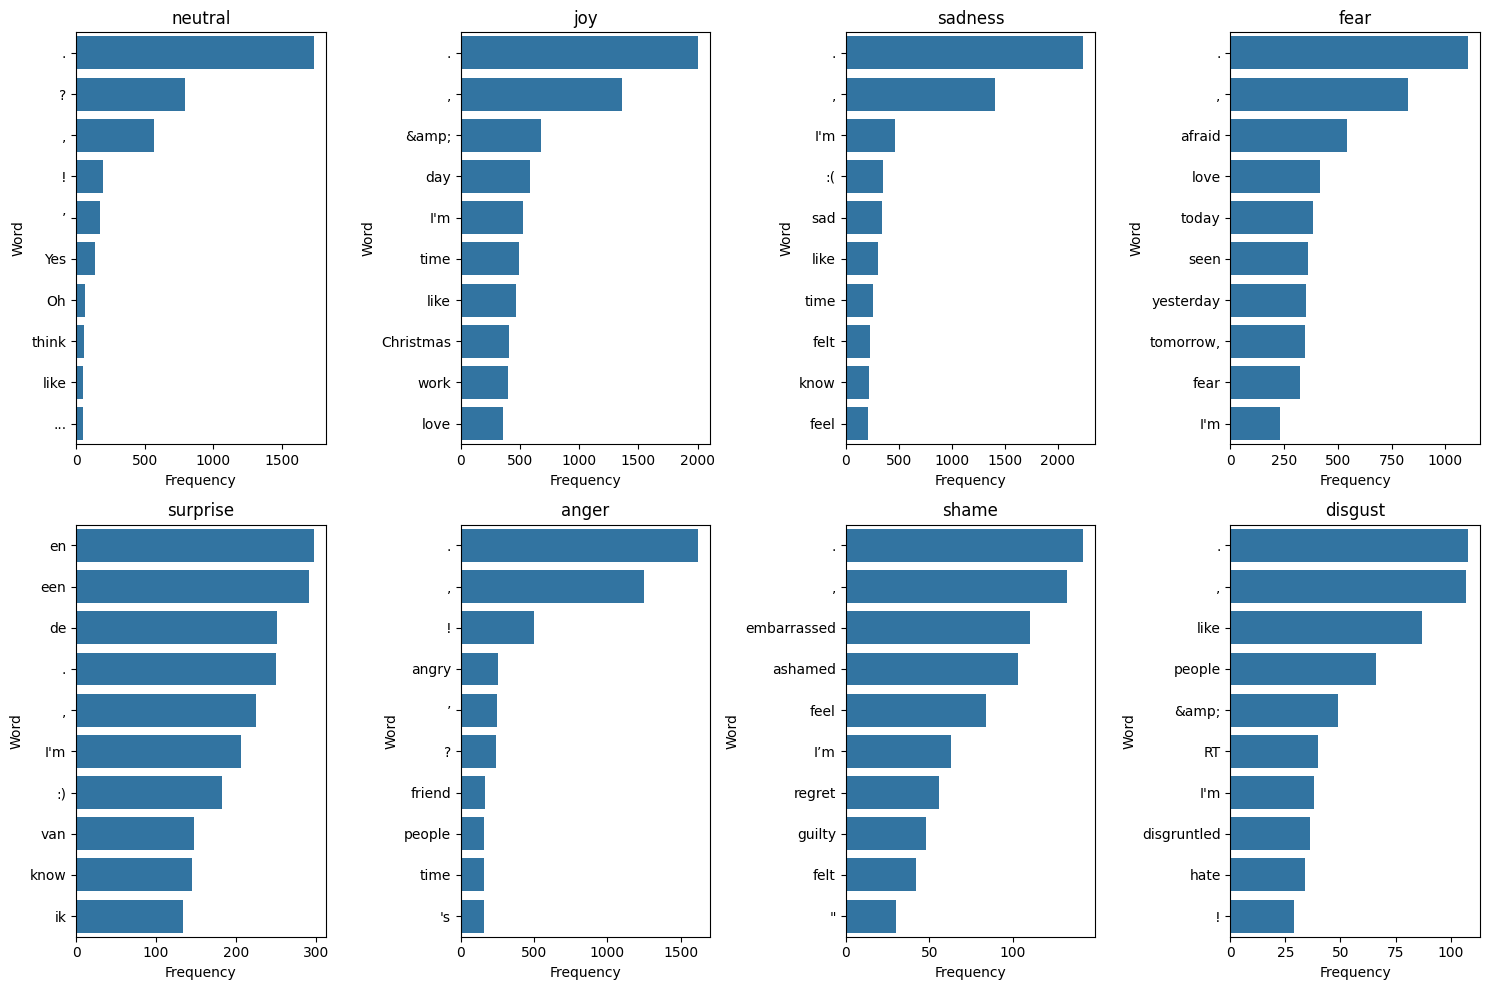

In [39]:
sentiments = augmented_df['Emotion'].unique()
plt.figure(figsize=(15, 10))
top_n = 10
for i, sentiment in enumerate(sentiments, 1):
    plt.subplot(2, 4, i)
    text = ' '.join(augmented_df[augmented_df['Emotion'] == sentiment]['Clean_Text'])
    words = text.split()
    word_freq = Counter(words)
    top_words = word_freq.most_common(top_n)
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=top_words_df)
    plt.title(sentiment)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
plt.tight_layout()
plt.show()

Aquí podemos ver que los caracteres especiales y signos de puntuación podrían crear un poco de ruido a la hora de entrenar nuestro modelo, por lo que los eliminamos y hacemos el análisis de repetición de palabras por emoción.

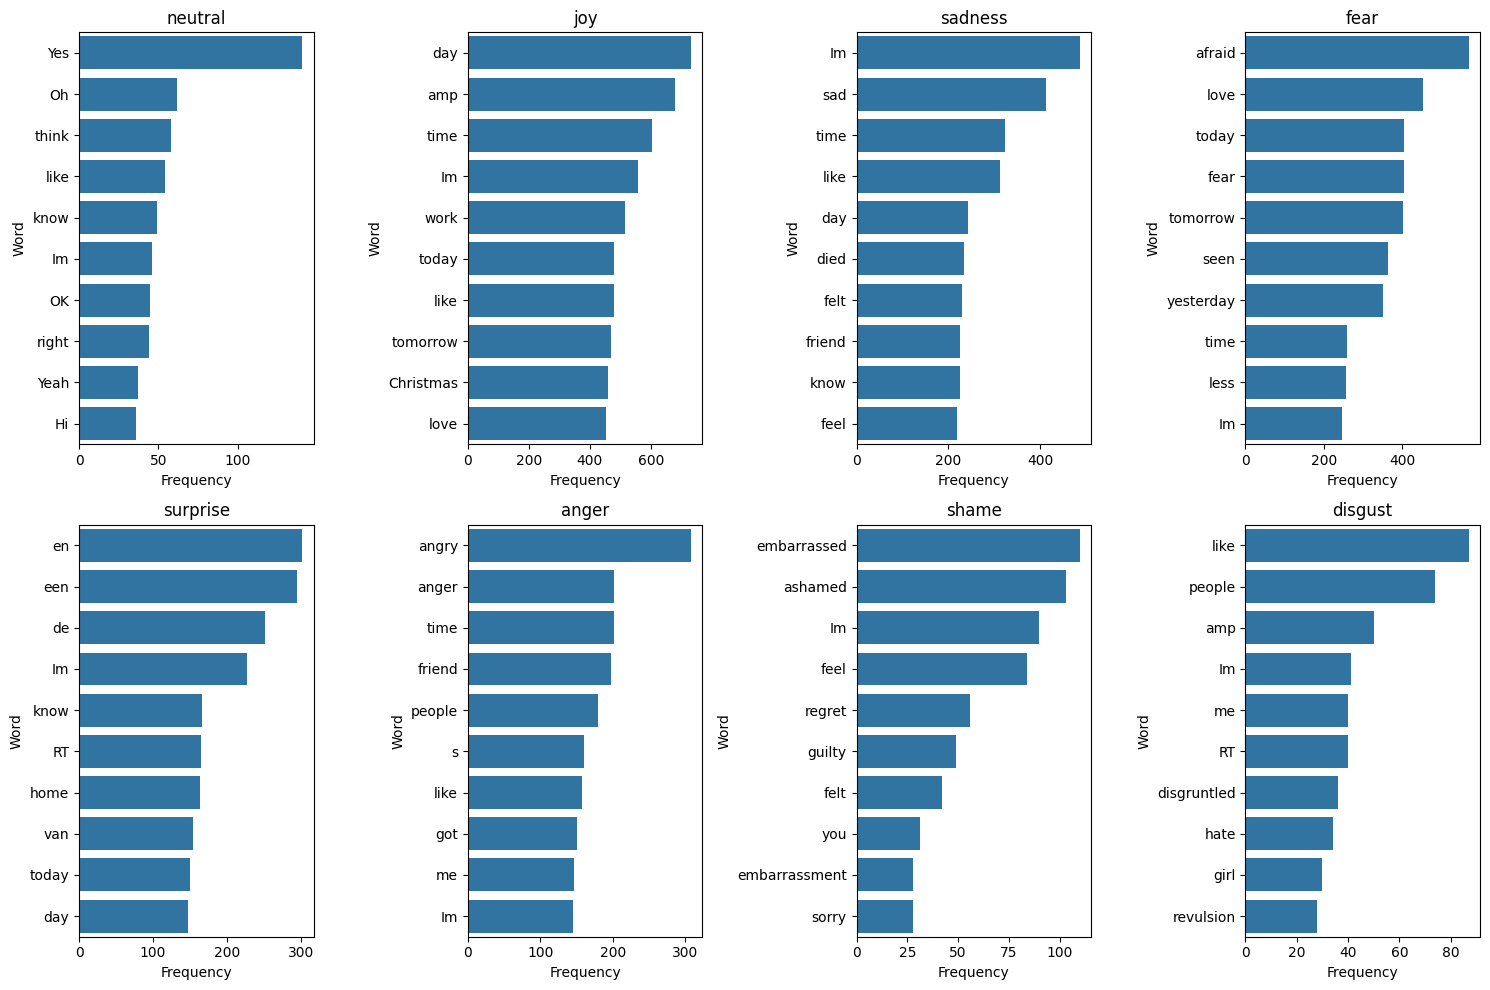

In [40]:
augmented_df['Clean_Text'] = augmented_df['Clean_Text'].apply(nfx.remove_special_characters)
plt.figure(figsize=(15, 10))
top_n = 10
for i, sentiment in enumerate(sentiments, 1):
    plt.subplot(2, 4, i)
    text = ' '.join(augmented_df[augmented_df['Emotion'] == sentiment]['Clean_Text'])
    words = text.split()
    word_freq = Counter(words)
    top_words = word_freq.most_common(top_n)
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=top_words_df)
    plt.title(sentiment)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
plt.tight_layout()
plt.show()

A partir del análisis proponemos la implementación de diferentes algoritmos para la clasificación multiclase de nuestros textos, todos mediante un enfoque supervisado y la división entre set de entrenamiento y de prueba, para comprobar cuál es la mejor alternativa dados los datos obtenidos.

## Entrenamiento de los modelos

Cabe apuntar que la vectorización de nuestras oraciones se hace de cierta manera "in-place" a la hora de entrenar a los modelos, esto gracias a una de las funcionalidades internas de la biblioteca de machine learning "scikitlearn" llamada "count_vectorizer" que se encarga de transformar las oraciones en matrices que cunetan los "tokens" dentro del vocabulario obtenido a través de todas las observaciones con las que se entrena el modelo, esto sirve excelente para nuestro enfoque basado en las palabras clave por sentimiento.

Primero hacemos la separación entre variable dependiente e independiente así como de los sets de entrenamiento y prueba:

In [44]:
x = augmented_df['Clean_Text']
y = augmented_df['Emotion']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

Ahora procedemos a entrenar tres diferentes modelos para hacer la comparación de su efectividad con nuestro dataset:

## Regresión Logística

In [45]:
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])
pipe_lr.fit(x_train,y_train)

/home/champloo/unam/ia/proyecto2/text_emotion_detection/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6196637703060068

## Support Vector Classification

In [46]:
pipe_svm = Pipeline(steps=[('cv',CountVectorizer()),('svc', SVC(kernel = 'rbf', C = 10))])
pipe_svm.fit(x_train,y_train)

0.6215527011711371

## Random Forest Classifier

In [47]:
pipe_rf = Pipeline(steps=[('cv',CountVectorizer()),('rf', RandomForestClassifier(n_estimators=10))])
pipe_rf.fit(x_train,y_train)

0.5637514166981489

# Evaluación de los modelos

Primero veamos el la precisión de los modelos que acabamos de entrenar:

In [48]:
lr_score = pipe_lr.score(x_test,y_test)
svc_score = pipe_svm.score(x_test,y_test)
rf_score = pipe_rf.score(x_test,y_test)
print(f"##Score general##\n regresión logística: {lr_score}\n SVC: {svc_score}\n random forest: {rf_score}")

##Score general##
 regresión logística: 0.6196637703060068
 SVC: 0.6215527011711371
 random forest: 0.5637514166981489


Notemos que los mejores resultados fueron obtenidos con SVC, por lo que continuaremos con el análisis de sus resultados específicos:

In [50]:
predicted = pipe_svm.predict(x_test)
print(predicted)

['joy' 'joy' 'joy' ... 'joy' 'joy' 'joy']


## Matriz de confusión

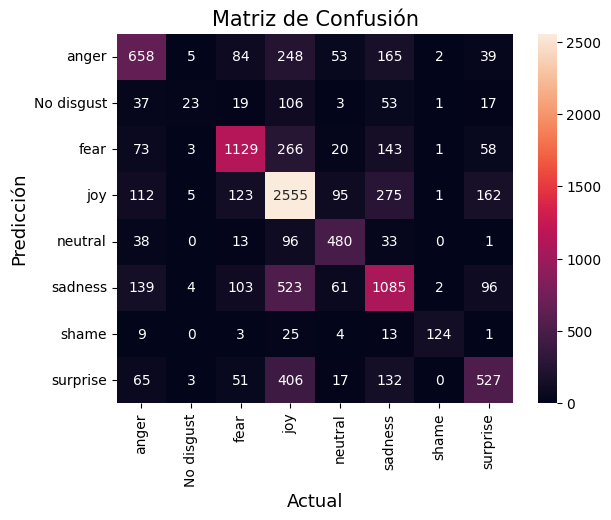

In [54]:
confusion = confusion_matrix(y_test, predicted)
sns.heatmap(confusion,
            annot=True,
            fmt='g',
            xticklabels=['anger', 'No disgust', 'fear', 'joy', 'neutral', 'sadness', 'shame', 'surprise'],
            yticklabels=['anger', 'No disgust', 'fear', 'joy', 'neutral', 'sadness', 'shame', 'surprise'])
plt.ylabel('Predicción', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Matriz de Confusión', fontsize=15)
plt.show()

## Scores generales

In [53]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

       anger       0.58      0.52      0.55      1254
     disgust       0.53      0.09      0.15       259
        fear       0.74      0.67      0.70      1693
         joy       0.60      0.77      0.68      3328
     neutral       0.65      0.73      0.69       661
     sadness       0.57      0.54      0.55      2013
       shame       0.95      0.69      0.80       179
    surprise       0.58      0.44      0.50      1201

    accuracy                           0.62     10588
   macro avg       0.65      0.56      0.58     10588
weighted avg       0.62      0.62      0.61     10588



Notemos que nuestro modelo es excelente para detectar con precisión la emoción de shame, aunque no tiene el mejor recall, vemos también que falla bastante en clasificar sentimientos que tienen palabras parecidas como lo son disgust, anger y sadness. Así mismo vale la pena observar que incluso con la cantidad de ejemplos que tiene "joy", el modelo no parece tener un overfitting sobre esta etiqueta. Consideramos que para poder crear un modelo con mejores resultados es necesario indudablemente una mayor cantidad de datos que igualen en números a la etiqueta "joy", así mismo creemos que, al ser oraciones pequeñas, el análisis de palabras clave resulta un poco ineficiente, aunque sostenemos que es la mejor opción dado el tamaño general de las oraciones y el propósito del modelo.